In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import kstest
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("train.csv")

## Create One Hot Encoded Variable

In [3]:
#nominal variables are suited for one-hot encoding.  Garage Finish was choosen because of it correlation to SalePrice
#greater than 50%
GarageFinishDummyVar=pd.get_dummies(pd.DataFrame(data["GarageFinish"]), columns=['GarageFinish'], prefix='GarageFinish')

## Create Polynomial Variable

In [4]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(np.array(data["GrLivArea"]).reshape(-1, 1))

In [5]:
poly1=[]
poly2=[]
for i in X_poly:
    poly1.append(i[0])
    poly2.append(i[1])

In [6]:
data=pd.concat([data, GarageFinishDummyVar, pd.Series(poly1, name="GrLivArea1"), pd.Series(poly2, name="GrLivArea2")], axis=1)

In [7]:
y=data["SalePrice"]
X=data.drop(["Id", "SalePrice", "GarageFinish", "GrLivArea"], axis=1)

## Label Categorical Variables

In [8]:
X_dict={}
for i in X.columns:
    labeler=LabelEncoder()
    X_dict[i]=labeler.fit_transform(data[i])

In [9]:
X_from_labeler=pd.DataFrame.from_dict(X_dict)

## Normality Test (Kolmogorov-Smirnov Test)

In [10]:
for i in X_from_labeler.columns:
    stat, p = kstest(X_from_labeler[i], 'norm', args=(X_from_labeler[i].mean(), X_from_labeler[i].std()))
    print(f'Statistic={stat:.3f}, p-value={p:.3f}')

Statistic=0.209, p-value=0.000
Statistic=0.420, p-value=0.000
Statistic=0.152, p-value=0.000
Statistic=0.061, p-value=0.000
Statistic=0.521, p-value=0.000
Statistic=0.534, p-value=0.000
Statistic=0.407, p-value=0.000
Statistic=0.521, p-value=0.000
Statistic=0.510, p-value=0.000
Statistic=0.448, p-value=0.000
Statistic=0.536, p-value=0.000
Statistic=0.103, p-value=0.000
Statistic=0.466, p-value=0.000
Statistic=0.508, p-value=0.000
Statistic=0.495, p-value=0.000
Statistic=0.319, p-value=0.000
Statistic=0.155, p-value=0.000
Statistic=0.320, p-value=0.000
Statistic=0.124, p-value=0.000
Statistic=0.175, p-value=0.000
Statistic=0.479, p-value=0.000
Statistic=0.533, p-value=0.000
Statistic=0.283, p-value=0.000
Statistic=0.280, p-value=0.000
Statistic=0.380, p-value=0.000
Statistic=0.333, p-value=0.000
Statistic=0.367, p-value=0.000
Statistic=0.520, p-value=0.000
Statistic=0.264, p-value=0.000
Statistic=0.260, p-value=0.000
Statistic=0.515, p-value=0.000
Statistic=0.402, p-value=0.000
Statisti

## Correlation Analysis (Feature Selection)

In [11]:
correlation_plot=pd.concat([X_from_labeler, y], axis=1).corr()

## Check for Muilticollinearity (80% Correlation or Greater)

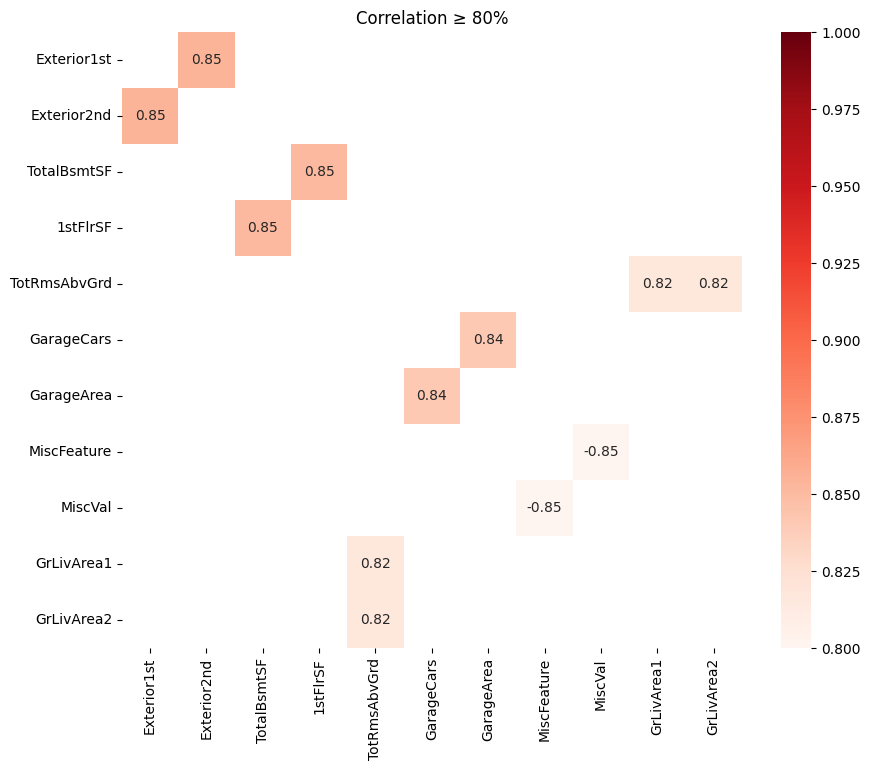

In [12]:
filtered_corr = correlation_plot[(correlation_plot.abs() >= 0.8) & (correlation_plot.abs() < 1.0)]
filtered_corr = filtered_corr.dropna(how='all').dropna(axis=1, how='all')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap="Reds", vmin=0.8, vmax=1.0)
plt.title("Correlation ≥ 80%")
plt.show()

In [13]:
correlation_plot[(correlation_plot.SalePrice>=.5)].SalePrice

OverallQual     0.790982
YearBuilt       0.534949
YearRemodAdd    0.507101
TotalBsmtSF     0.620870
1stFlrSF        0.590882
FullBath        0.560664
TotRmsAbvGrd    0.534591
GarageCars      0.640409
GarageArea      0.639584
GrLivArea1      0.689795
GrLivArea2      0.689795
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [14]:
feature_list=correlation_plot[(correlation_plot.SalePrice>.5) | (correlation_plot.SalePrice<-.5)].reset_index().iloc[:,0]
print(list(feature_list))

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'GrLivArea1', 'GrLivArea2', 'SalePrice']


In [15]:
updated={}
for i in list(feature_list)[:-1]:
    updated[i]=X_from_labeler[i]

In [16]:
updated_dataset=pd.DataFrame.from_dict(updated)

In [17]:
lr_updated_dataset=updated_dataset.drop(["1stFlrSF", "TotRmsAbvGrd", "GarageArea"], axis=1)

##  Prepare Test Dataset

In [18]:
test=pd.read_csv("test.csv")

In [19]:
testX_poly = poly.fit_transform(np.array(test["GrLivArea"]).reshape(-1, 1))

In [20]:
testpoly1=[]
testpoly2=[]
for i in testX_poly:
    testpoly1.append(i[0])
    testpoly2.append(i[1])

In [21]:
testdata=pd.concat([test, pd.Series(testpoly1, name="GrLivArea1"), pd.Series(testpoly2, name="GrLivArea2")], axis=1)

In [22]:
test_updated={}
for i in list(feature_list)[:-1]:
    test_updated[i]=testdata[i]

test_updated_dataset=pd.DataFrame.from_dict(test_updated)

In [23]:
test_X_dict={}
for i in test_updated_dataset.columns:
    labeler=LabelEncoder()
    test_X_dict[i]=labeler.fit_transform(test_updated_dataset[i])

In [24]:
test_updated_dataset=pd.DataFrame.from_dict(test_X_dict)

## Standardize Data

In [25]:
standardizer=StandardScaler()
standar_dta=standardizer.fit_transform(updated_dataset) 
lr_standar_dta=standardizer.fit_transform(lr_updated_dataset) 
teststandar_dta=standardizer.fit_transform(test_updated_dataset)

In [26]:
standardized_dataset=pd.DataFrame(standar_dta)
lr_standardized_dataset=pd.DataFrame(lr_standar_dta)
teststandardized_dataset=pd.DataFrame(teststandar_dta)

In [27]:
standardized_dataset.columns=updated_dataset.columns
lr_standardized_dataset.columns=lr_standardized_dataset.columns
teststandardized_dataset.columns=test_updated_dataset.columns

In [28]:
lr_teststandardized_dataset=teststandardized_dataset.drop(["1stFlrSF", "TotRmsAbvGrd", "GarageArea"], axis=1)

## Logistic Regression Model

In [29]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [30]:
lr=LogisticRegression()

In [31]:
lr.fit(lr_standardized_dataset, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [32]:
n_scores = cross_val_score(lr, lr_standardized_dataset, y, scoring=make_scorer(r2_score), cv=cv, n_jobs=-1)
print("Mean R²:", np.mean(n_scores))

Mean R²: 0.641319569059744


In [33]:
lr_predictions=lr.predict(lr_teststandardized_dataset)

In [34]:
pd.concat([pd.Series(test["Id"], name="Id"), pd.Series(np.maximum(lr_predictions, 0), name="SalePrice")], axis=1).to_csv("HousePrice_Submission1.csv", index=False)

## Ridge Regression Model

In [35]:
ridge=Ridge()

In [36]:
ridge.fit(standardized_dataset, y)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [37]:
n_scores = cross_val_score(ridge, standardized_dataset, y, scoring=make_scorer(r2_score), cv=cv, n_jobs=-1)
print("Mean R²:", np.mean(n_scores))

Mean R²: 0.7894089242987673


In [38]:
ridge_predictions=ridge.predict(teststandardized_dataset)

In [39]:
pd.concat([pd.Series(test["Id"], name="Id"), pd.Series(np.maximum(ridge_predictions, 0), name="SalePrice")], axis=1).to_csv("HousePrice_Submission2.csv", index=False)